**Аналитическое решение:**

$$u(x,y)={y^3\over 3}+{x^2\over 4}-{x^4\over 6}-{y^4\over 6}$$ 

**Тачность численного решения оценим по 1-ой метрики:**

In [69]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import seaborn as sns

Шаг по времени будем выбирать упорядоченным оптимальным набором чебышевских параметров через функцию для **$mu[i-1][j-1]$**:

In [70]:
L = 5
M = 5

xx = np.linspace(-0.5, 0.5, L+1)
yy = np.linspace(0, 1, M+1)

hx = np.diff(xx)[0]
hy = np.diff(yy)[0]

mu = np.zeros([L+1, M+1])
for i in range(1, L+2):
    for j in range(1, M+2):
        mu[i-1][j-1] = 4 * ( ( sin(i*pi/(2*L)) / hx )**2 + ( sin(j*pi/(2*M)) / hy )**2 )

In [71]:
mu_m = np.amin(mu)
mu_M = np.amax(mu)

mu_m, mu_M

(19.09830056250525, 200.0)

In [72]:
# mu_m = 2*(pi**2)
# mu_M = 4*(L**2 + M**2)

# mu_m, mu_M

Минимальное число шагов по времени:

In [73]:
eps = 1e-3
N_min = log(2/eps)/log((sqrt(mu_M) + sqrt(mu_m))/(sqrt(mu_M) - sqrt(mu_m)))
N_min

11.896550228335862

In [74]:
N = 32
tau_n = lambda n: 2 / (mu_M + mu_m + (mu_M-mu_m)*cos(pi*(2*n-1)/(2*N)))

In [75]:
N_arr = [N]
while N != 1:
    if N % 2 == 0:
        N = int(N/2)
        N_arr.append(N)
    else:
        N = N - 1
        N_arr.append(N)

N_arr

[32, 16, 8, 4, 2, 1]

In [76]:
highlighted = []
highlighted.append(N_arr[1])
for i in range(len(N_arr)):
    if (i>0) and (i<len(N_arr)-1):
        if (N_arr[i] % 2 == 0) and (N_arr[i-1] % 2 == 1) and (N_arr[i+1] % 2 == 1):
            highlighted.append(N_arr[i])

N_arr = N_arr[::-1]
highlighted

[16]

In [77]:
Ntoi = {}
for i, N in enumerate(N_arr):
    Ntoi[N] = i

Вычисляем тэты:

In [78]:
thetas = [[] for n in N_arr]

for i, N in enumerate(N_arr):
    m = N//2
    if N % 2 == 0:
        thetas[Ntoi[2*m]] = [0]*(2*m + 1)
        if N in highlighted:
            for i in range(1, m+1):
                thetas[Ntoi[2*m]][2*i-1] = thetas[Ntoi[m]][i]
                thetas[Ntoi[2*m]][2*i] = 4*m + 2 - thetas[Ntoi[2*m]][2*i-1]
        else:
            for i in range(1, m+1):
                thetas[Ntoi[2*m]][2*i-1] = thetas[Ntoi[m]][i]
                thetas[Ntoi[2*m]][2*i] = 4*m - thetas[Ntoi[2*m]][2*i-1]
    else:
        thetas[Ntoi[2*m + 1]] = [0]*(2*m + 2)
        if N_arr[i-1] in highlighted and i>0:
            for i in range(1, 2*m+1):
                thetas[Ntoi[2*m + 1]][i] = thetas[Ntoi[2*m]][i]
            thetas[Ntoi[2*m + 1]][2*m + 1] = 2*m+1
        else:
            for i in range(1, 2*m+1):
                thetas[Ntoi[2*m + 1]][i] = thetas[Ntoi[2*m]][i]
            thetas[Ntoi[2*m + 1]][2*m + 1] = 4*m+1

thetas = [theta[1:] for theta in thetas]
tau_nn = [int((x+1)/2) for x in thetas[Ntoi[N]]]

In [79]:
tauu = [tau_n(n) for n in tau_nn]

In [80]:
F = [[2*y*(1-y) + 0.5*(1-4*(x**2)) for y in yy] for x in xx]
u0 = lambda x, y: 0

u_curr = [[u0(x, y) for y in yy] for x in xx]
u_prev = np.zeros([L+1, M+1])

In [81]:
for i in range(1):
    for n in range(N):
        u_prev = u_curr
        u_curr = np.zeros([L+1, M+1])
        for l in range(L+1):
            for m in range(M+1):
                if (l == 0) or (m == 0) or (l == L) or (m == M):
                    u_curr[l][m] = 0
                else:
                    tau = tauu[n]
                    u_curr[l][m] = u_prev[l][m] + (tau/(hx**2))*(u_prev[l+1][m]-2*u_prev[l][m]+u_prev[l-1][m]) + (tau/(hy**2))*(u_prev[l][m+1]-2*u_prev[l][m]+u_prev[l][m-1]) - tau*F[l][m]

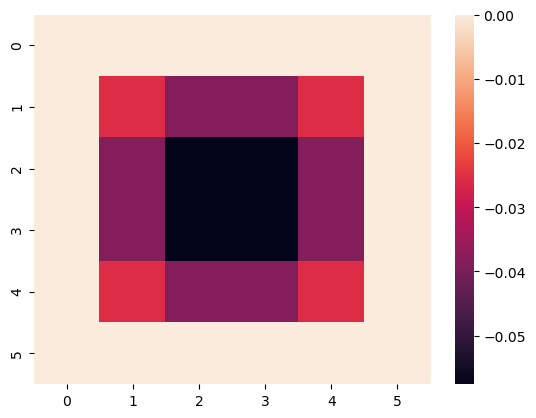

In [82]:
sns.heatmap(u_curr) 
plt.show()

In [83]:
u_curr[L//2][M//2]

-0.05759999979763268

In [84]:
xx[3]

0.10000000000000009

In [85]:
yy[3]

0.6000000000000001

In [86]:
u_curr[3][3]

-0.057599999797632695

Высчитываем аналитическое решение:

In [87]:
f_an = lambda x, y: y*(1-y)*(1-4*x**2)*(-0.25)

In [88]:
def sol(i, j):
    x = xx[i]
    y = yy[j]
    uc = u_curr[i][j]
    uan = f_an(x, y)
    return (uc, uan, abs(uan - uc))

Точность численного решения:

In [89]:
d = 0
for i in range(len(xx)):
    for j in range(len(yy)):
        x = xx[i]
        y = yy[j]
        uc = u_curr[i][j]
        uan = f_an(x, y)
        d = max(d, abs(uan - uc))

print()

In [90]:
xx[3], yy[3]

(0.10000000000000009, 0.6000000000000001)

Конечный вывод: численное решение/ аналитическое решение/ первая норма размерности

In [91]:
sol(3, 3)

(-0.057599999797632695, -0.0576, 2.02367303470119e-10)